<a href="https://colab.research.google.com/github/Debayan45/Color-Analysis-using-AI/blob/main/Color_recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving pexels-pixabay-415829.jpg to pexels-pixabay-415829 (1).jpg
Detected Skin Tone RGB: [191 159 142]
Detected Pupil Color RGB: [156 125 124]
Suggested Dress Colors: ['Grey', 'Peach', 'Burgundy']


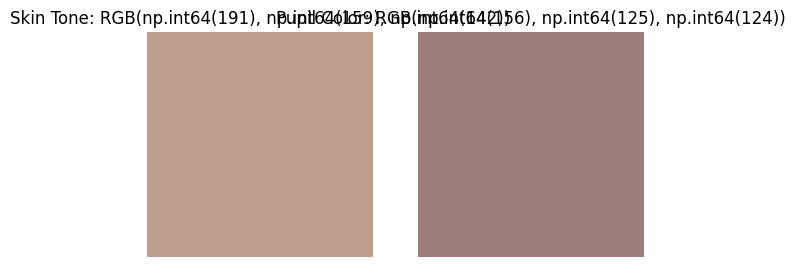

In [2]:
from IPython.display import display
from PIL import Image
import cv2
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from google.colab import files
import requests

# 1. Upload Image
uploaded = files.upload()
filename = next(iter(uploaded))
image = cv2.imdecode(np.frombuffer(uploaded[filename], np.uint8), cv2.IMREAD_COLOR)

# 2. Extract Skin Region
def extract_skin(image):
    img_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower = np.array([0, 20, 70], dtype=np.uint8)
    upper = np.array([20, 255, 255], dtype=np.uint8)
    mask = cv2.inRange(img_hsv, lower, upper)
    skin = cv2.bitwise_and(image, image, mask=mask)
    return skin

# 3. Extract Eye Pupil Color
def extract_pupil_color(image):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    for (x, y, w, h) in faces:
        roi_face = image[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(cv2.cvtColor(roi_face, cv2.COLOR_BGR2GRAY))

        for (ex, ey, ew, eh) in eyes[:1]:  # First detected eye
            eye_roi = roi_face[ey:ey+eh, ex:ex+ew]
            return dominant_color(eye_roi, k=1)[0]

    return [0, 0, 0]  # Fallback if no pupil detected

# 4. Dominant Color Finder
def dominant_color(image, k=1):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pixels = image.reshape((-1, 3))
    pixels = pixels[np.any(pixels != [0, 0, 0], axis=1)]  # Remove black
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(pixels)
    return kmeans.cluster_centers_.astype(int)

# 5. Mock Suggestion Logic (replace with API if needed)
def suggest_dress_colors(skin_rgb, pupil_rgb):
    r_s, g_s, b_s = skin_rgb
    r_e, g_e, b_e = pupil_rgb

    if r_s > 180:
        skin_tone_type = "Fair"
    elif r_s > 100:
        skin_tone_type = "Medium"
    else:
        skin_tone_type = "Dark"

    if r_e < 60 and g_e < 60 and b_e < 60:
        eye_type = "Black"
    elif b_e > r_e and b_e > g_e:
        eye_type = "Blue"
    elif g_e > r_e:
        eye_type = "Green"
    else:
        eye_type = "Brown"

    suggestions = {
        ("Fair", "Blue"): ["Soft Pink", "Lavender", "Powder Blue"],
        ("Fair", "Black"): ["Sky Blue", "Light Coral", "White"],
        ("Medium", "Brown"): ["Olive", "Rust", "Emerald"],
        ("Medium", "Black"): ["Maroon", "Mustard", "Navy"],
        ("Dark", "Black"): ["Ivory", "Yellow", "Royal Blue"],
        ("Dark", "Brown"): ["Teal", "Orange", "Beige"],
    }

    return suggestions.get((skin_tone_type, eye_type), ["Grey", "Peach", "Burgundy"])

# 6. Run Analysis
skin = extract_skin(image)
skin_color = dominant_color(skin, k=1)[0]
pupil_color = extract_pupil_color(image)

print("Detected Skin Tone RGB:", skin_color)
print("Detected Pupil Color RGB:", pupil_color)

suggestions = suggest_dress_colors(skin_color, pupil_color)
print("Suggested Dress Colors:", suggestions)

# 7. Show Detected Colors
fig, ax = plt.subplots(1, 2)
ax[0].imshow([[skin_color / 255]])
ax[0].set_title(f"Skin Tone: RGB{tuple(skin_color)}")
ax[0].axis("off")

ax[1].imshow([[pupil_color / 255]])
ax[1].set_title(f"Pupil Color: RGB{tuple(pupil_color)}")
ax[1].axis("off")

plt.show()

